<a href="https://colab.research.google.com/github/changsksu/IMSE_Data_Science/blob/main/2k_factorial_via_Sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Python notebook demonstrates the computation of Two-Level factorial experimental analysis using sklearn and statmodel.
We take the advantage of the polynomial generation feature to generate full dimension of the design matrix x using sklearn PolynomialFeature. The example is from Montgomery Intro to SQC (7th ed chap 13 Ex 13.6 Router Experiment).  Ref.
https://www.statsmodels.org/stable/regression.html#examples

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html


In [ ]:
import math
import random
import scipy
import statistics
import numpy as np
import scipy.stats
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#the 2nd read option assume that the data file is rignt under your default google drive directory
#note that the path is case sensitive
#use a text editor such as notepad to see the seperator dividing data
#go the 1st read option for local file: see the Read data from local file notebook for an example
# factor A is bit size and factor B is speed and the response is vibration
data = pd.read_csv('drive/My Drive/Colab Notebooks/IMSE_Data_Science/Data/Ex13-6 Router Experiment 2k k=2.csv', sep=',', na_values=".")

data

A  B  Vibration
0  -1 -1       18.2
1   1 -1       27.3
2  -1  1       15.9
3   1  1       41.0
4  -1 -1       18.9
5   1 -1       24.0
6  -1  1       14.5
7   1  1       43.9
8  -1 -1       12.9
9   1 -1       22.4
10 -1  1       15.1
11  1  1       36.3
12 -1 -1       14.4
13  1 -1       22.5
14 -1  1       14.2
15  1  1       39.9

The F test from one-way ANOVA is used to test
**H0: tau5%=tau10%=tau15%=mtau20%=0 **vs
H1: at least one tau <>0
Since the pvalue is very small, we would reject H0 and conclude that
there is a difference in paper strenght influenced by hardwood concentration

In [ ]:
df=data #df means data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   A          16 non-null     int64  
 1   B          16 non-null     int64  
 2   Vibration  16 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 512.0 bytes


In [ ]:
X=df[['A', 'B']]
X

A  B
0  -1 -1
1   1 -1
2  -1  1
3   1  1
4  -1 -1
5   1 -1
6  -1  1
7   1  1
8  -1 -1
9   1 -1
10 -1  1
11  1  1
12 -1 -1
13  1 -1
14 -1  1
15  1  1

In [ ]:
# convert x1 and x2 input columns into a 2nd order polynomial matrix with intercept column
# computation is done in numpy and convert it into Panda dataframe
xx=X.to_numpy()
poly= PolynomialFeatures(degree=2, interaction_only=True)
xxpd=pd.DataFrame(poly.fit_transform(xx), columns=['I', 'x1', 'x2', 'x1x2']) #if interaction_only=False, then 1, x1, x2, x1^2, x1x2, x2^2
xxpd

I   x1   x2  x1x2
0   1.0 -1.0 -1.0   1.0
1   1.0  1.0 -1.0  -1.0
2   1.0 -1.0  1.0  -1.0
3   1.0  1.0  1.0   1.0
4   1.0 -1.0 -1.0   1.0
5   1.0  1.0 -1.0  -1.0
6   1.0 -1.0  1.0  -1.0
7   1.0  1.0  1.0   1.0
8   1.0 -1.0 -1.0   1.0
9   1.0  1.0 -1.0  -1.0
10  1.0 -1.0  1.0  -1.0
11  1.0  1.0  1.0   1.0
12  1.0 -1.0 -1.0   1.0
13  1.0  1.0 -1.0  -1.0
14  1.0 -1.0  1.0  -1.0
15  1.0  1.0  1.0   1.0

Note that the x1^2 and X2^2 columns are all 1s. This phenomial is due the lack of center points and middle level points in the design matrix X. We will introduce a CCD (central composite design) to take care of it.

In [ ]:
# generate model = b0 + b1x1 + b2x2 + b12 x1x2
# this is a model for 2^k factorial design so 2nd order terms are not estimatable
X=xxpd[['x1', 'x2', 'x1x2']]
X

x1   x2  x1x2
0  -1.0 -1.0   1.0
1   1.0 -1.0  -1.0
2  -1.0  1.0  -1.0
3   1.0  1.0   1.0
4  -1.0 -1.0   1.0
5   1.0 -1.0  -1.0
6  -1.0  1.0  -1.0
7   1.0  1.0   1.0
8  -1.0 -1.0   1.0
9   1.0 -1.0  -1.0
10 -1.0  1.0  -1.0
11  1.0  1.0   1.0
12 -1.0 -1.0   1.0
13  1.0 -1.0  -1.0
14 -1.0  1.0  -1.0
15  1.0  1.0   1.0

# Method 1. predicted response using skleran LinearRegression fit

In [ ]:
# predicted response using skleran LinearRegression fit
Y=df[['Vibration']]
regr=LinearRegression()
regr.fit(X,Y)
Yhat=regr.predict(X)
Yhat

array([[16.1  ],
       [24.05 ],
       [14.925],
       [40.275],
       [16.1  ],
       [24.05 ],
       [14.925],
       [40.275],
       [16.1  ],
       [24.05 ],
       [14.925],
       [40.275],
       [16.1  ],
       [24.05 ],
       [14.925],
       [40.275]])

In [ ]:
# compute residuals
Yobs=Y.to_numpy()
#eij= Yobs - regr.predict(X)
eij= Yobs - Yhat
eij

array([[ 2.1  ],
       [ 3.25 ],
       [ 0.975],
       [ 0.725],
       [ 2.8  ],
       [-0.05 ],
       [-0.425],
       [ 3.625],
       [-3.2  ],
       [-1.65 ],
       [ 0.175],
       [-3.975],
       [-1.7  ],
       [-1.55 ],
       [-0.725],
       [-0.375]])

In [ ]:
# regression coefficients without the beta 0 term
regr.coef_

array([[8.325 , 3.7625, 4.35  ]])

In [ ]:
# beta 0 term
regr.intercept_

array([23.8375])

# Method 2. Using StatModel OLS

In [ ]:
# add the column of 1s into the design matrix X
# another way is to reconstruct X using xxpd from the previous code cell
# X=xxpd[['I', 'x1', 'x2', 'x1x2']]
X = sm.add_constant(X)
X

const   x1   x2  x1x2
0     1.0 -1.0 -1.0   1.0
1     1.0  1.0 -1.0  -1.0
2     1.0 -1.0  1.0  -1.0
3     1.0  1.0  1.0   1.0
4     1.0 -1.0 -1.0   1.0
5     1.0  1.0 -1.0  -1.0
6     1.0 -1.0  1.0  -1.0
7     1.0  1.0  1.0   1.0
8     1.0 -1.0 -1.0   1.0
9     1.0  1.0 -1.0  -1.0
10    1.0 -1.0  1.0  -1.0
11    1.0  1.0  1.0   1.0
12    1.0 -1.0 -1.0   1.0
13    1.0  1.0 -1.0  -1.0
14    1.0 -1.0  1.0  -1.0
15    1.0  1.0  1.0   1.0

In [ ]:
# use statsmodels for OLS fitting and t statistics
# in this case, X is xxpd
model = sm.OLS(Y, X)
res=model.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:              Vibration   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     90.55
Date:                Wed, 20 Oct 2021   Prob (F-statistic):           1.65e-08
Time:                        14:47:32   Log-Likelihood:                -34.776
No. Observations:                  16   AIC:                             77.55
Df Residuals:                      12   BIC:                             80.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.8375      0.614     38.828      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


# Residual Analysis

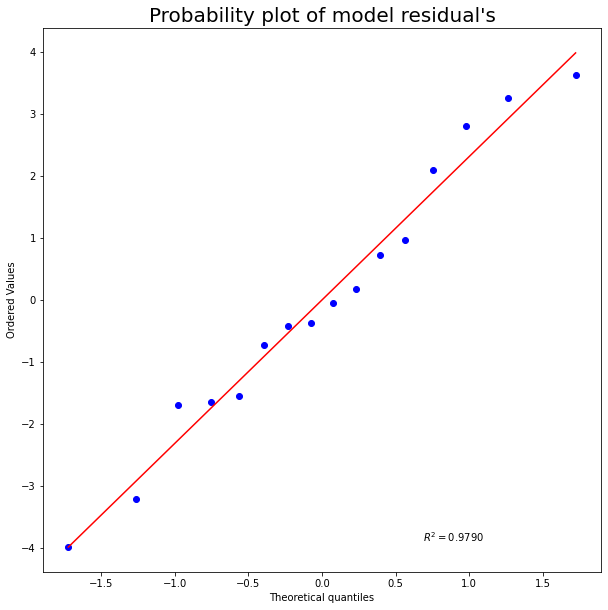

In [ ]:
# Residual Analysis
# normal check

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(res.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [ ]:
# Homogeneity of Variance check
# if the p value is small, reject H0 that the residuals have equal variance
# if the p value is large, cannot reject H0

stats.levene(df['Vibration'][df['A'] == -1],
             df['Vibration'][df['A'] == 1])


LeveneResult(statistic=39.38421796165487, pvalue=2.0368485334824388e-05)

Since p value is very small, we reject that factor A has equal variance

In [ ]:
# Homogeneity of Variance check
# if the p value is small, reject H0 that the residuals have equal variance
# if the p value is large, cannot reject H0

stats.levene(df['Vibration'][df['B'] == -1],
             df['Vibration'][df['B'] == 1])

LeveneResult(statistic=45.571873992043834, pvalue=9.30875979796417e-06)

The p value of the Levene is very large. We don't have evidence to conclude that the variances from different primer type are different

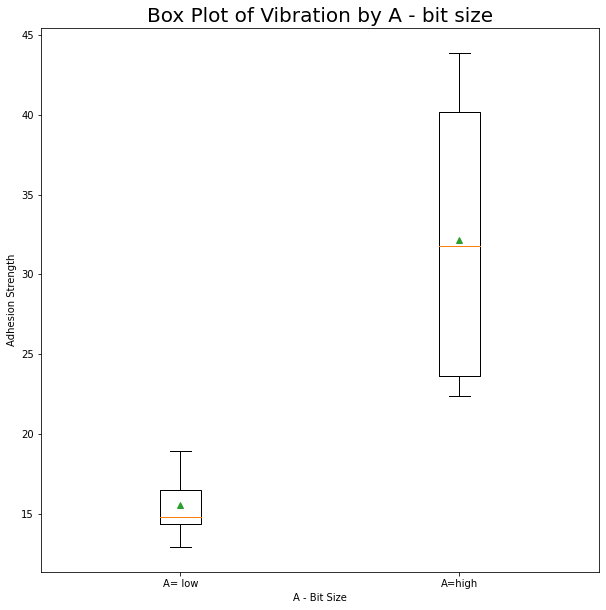

In [ ]:
# Box plots by factor Primer_type'
# If the IRQ=75% quartitle - 25% quartile are very different, then question the constant variance assumption
# If the F test p value is very small, we reject H0 and can use this box plot to identify the best factor level

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Vibration by A - bit size", fontsize= 20)
ax.set

data2 = [df['Vibration'][df['A'] == -1],
             df['Vibration'][df['A'] == 1]]


ax.boxplot(data2,
           labels= ['A= low', 'A=high'],
           showmeans= True)

plt.xlabel("A - Bit Size")
plt.ylabel("Adhesion Strength")

plt.show()

There is not much difference in variation. The largest adhesion strength is due to type 2 primer type.

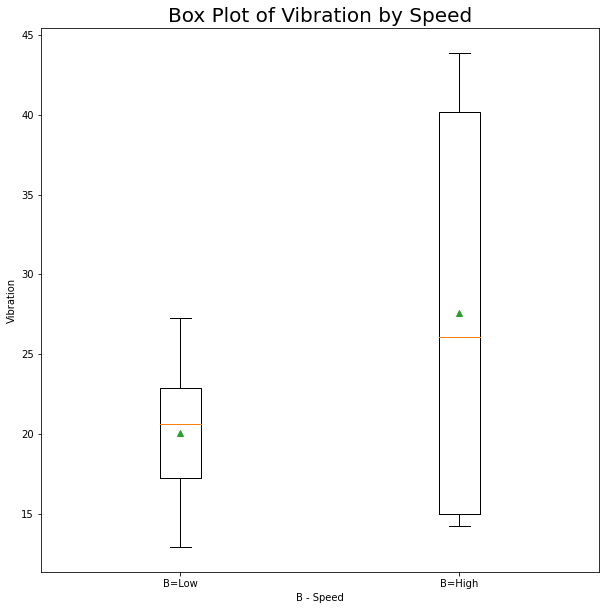

In [ ]:
# Box plots by factor Application Methods
# same instruction as the previous factor Primer types

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Vibration by Speed", fontsize= 20)
ax.set

data2 = [df['Vibration'][df['B'] == -1],
         df['Vibration'][df['B'] == +1]]


ax.boxplot(data2,
           labels= ['B=Low', 'B=High'],
           showmeans= True)

plt.xlabel("B - Speed")
plt.ylabel("Vibration")

plt.show()

There is not much difference in variation by application method. The largest adhesion strength is due to spraying method.

In [ ]:
# testing the random order for collecting observations
# Minitab calls the order variable, run order
# the following code generate a random order
# you should conduct your experiments using the random order generated
# for example, the first number is 5, it means that you will run the setting 5 in the experimentation table
# observation label 5 is primier type 3 and application method 2 (spraying)
# the run observation 11 and so on until all observations are collected
# import random (see the first cell)
N = len(eij)
c = list(range(0, N))
order = random.sample(c, N) # this should be replaced by the exact run order if the random order is not used
print('order of observations/residuals is')
print(order)

order of observations/residuals is
[12, 0, 6, 15, 9, 14, 11, 3, 2, 10, 13, 8, 5, 7, 4, 1]


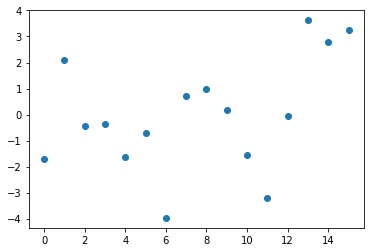

In [ ]:
# assume that this random order is how we collected the data in time sequence
# if there is no pattern in the scatter plot, then don't reject independence assumption

eij=res.resid

x = range(0,N) # from the first collected obs to the last in order
y = eij[order] # assign run order (see the previous code box)

plt.scatter(x, y)

The random order from the scatter plot above shows no pattern. If the data in the first half of the experiments are lower than 0 while those of the second half are above 0. Then there is a bias in data collection. If the residuals are small in the beginning but graduately increase. Or vice versa. It is a concern as well. In these cases, independence assumption is violated.

# Your turn:
can you run the Example 13.7 for k=3 factorial design and analysis? Hint: xxpd=pd.DataFrame(poly.fit_transform(xx), columns=['I', 'x1', 'x2', 'x3','x1x2', 'x1x3', 'x2x3', 'x1x2x3']). In this case, xxpd is the design matrix X.

Your turn: can you run the Example 13.7 for k=3 factorial design and analysis?
Hint: xxpd=pd.DataFrame(poly.fit_transform(xx), columns=['I', 'x1', 'x2', 'x3','x1x2', 'x1x3', 'x2x3', 'x1x2x3']). In this case, xxpd is the design matrix X.